# Usage guide
Copyright: Donghu Guo

Author: Donghu Guo

Description: This is the notebook showing the workflow of how to build, train PredAAE and use this model to make normal prediction and DA on one time step and the whole time steps. See the table of contents for a clearer understanding of the structure of this notebook.

Github Repository: https://github.com/ese-msc-2021/irp-dg321

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import joblib

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
%load_ext nb_black

In [3]:
sys.path.append("..")
# from tools import Data_preprocessing as t
import tools as t

<IPython.core.display.Javascript object>

In [4]:
root_path = '..data/' # set the root path where data is stored

<IPython.core.display.Javascript object>

### Load pod coefficients

In [5]:
# PCA model
pca_compress = joblib.load(
    root_path +
    'Cotrace_fixed_720_npys/train_pca_compress.pkl')
# POD coefficients
X_compressed = joblib.load(
    root_path +
    'Cotrace_fixed_720_npys/train_pod_coefficients.pkl')

scaler_minmax_train = MinMaxScaler((0, 1))
X_compressed = scaler_minmax_train.fit_transform(X_compressed)

<IPython.core.display.Javascript object>

In [6]:
ncoeffs = X_compressed.shape[1] # number of POD coefficients
ntimes = 9 # consecutive times for the AAE
step = 1 # step between times
BATCH_SIZE = 32

epochs = 10000

data_ct = t.concat_timesteps(X_compressed, ntimes, step)

<IPython.core.display.Javascript object>

### train and test split

In [7]:
train_ct, test_ct = t.train_test_split(data_ct, testFrac=0.0)

Training samples = 591 Testing samples = 0


<IPython.core.display.Javascript object>

In [8]:
# create dataset
train_dataset, X_train_4d = t.create_dataset(train_ct, ncoeffs, ntimes, BATCH_SIZE)
# test_dataset, X_test_4d = t.create_dataset(test_ct, ncoeffs, ntimes, BATCH_SIZE)

2022-08-02 20:08:03.229376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 20:08:03.856596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9648 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:60:00.0, compute capability: 7.5


<IPython.core.display.Javascript object>

In [9]:
print(X_train_4d.shape)

(591, 9, 550, 1)


<IPython.core.display.Javascript object>

In [10]:
print(train_ct.shape)
# print(test_ct.shape)

(591, 9, 550)


<IPython.core.display.Javascript object>

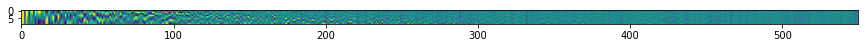

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(15,25))
plt.imshow(X_train_4d[0,:,:,0])

## Build network

### Current one

In [22]:
# model = t.PredAAE(**kwargs)
# model.make_PredAAE()
# hist,reconstruction = model.train(train_dataset, epochs)

# autoencoder = model.autoencoder
# enc_disc = model.enc_disc

In [23]:
def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', input_shape=[ntimes, ncoeffs, 1]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(latent_dim))
    return model

def make_decoder_model():
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(ntimes*ncoeffs*32, use_bias=False, activation='relu', input_shape=(latent_dim,)))
  model.add(keras.layers.Reshape((ntimes, ncoeffs, 32)))

  model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', output_padding=[0,0], use_bias=False, activation='sigmoid'))

  return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(240, activation="relu", input_shape=(latent_dim,)))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(120, activation="relu"))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(60, activation="relu"))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(1))
    return model

In [24]:
encoder = make_encoder_model()
decoder = make_decoder_model()
discriminator = make_discriminator_model()

autoencoder = keras.models.Sequential([encoder, decoder])
enc_disc = keras.models.Sequential([encoder, discriminator])

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

def compute_reconstruction_loss(x, x_logit):
    """
    Calculate mean square error 
    between the input of the encoder 
    and the output of the decoder 
    
    Parameters
    ----------
    x : Tensor 
      the input of the encoder
    x_logit : Tensor
      the output of the decoder

    Returns
    -------
    Tensor
      mean squared loss between x and x_logit
    """  
    reconstruction_loss = mse(x, x_logit)
    return reconstruction_loss

def compute_discriminator_loss(fake_output, real_output):
    """
    Calculate cross entropy loss 
    between random noise and one, 
    the output of the encoder and zero 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
    real_output : Tensor
      the result of the discriminator 
      on the output of random noise
      
    Returns
    -------
    Tensor
      the discrimination result
      on the output of the encoder and random noise
    """  
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def compute_generator_loss(fake_output):
    """
    Calculate cross entropy loss 
    between the output of the encoder and one 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
      
    Returns
    -------
    Tensor
      the cross entropy loss
      between the output of the encoder and one 
    """    
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    
reconstruction_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

r_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

# Notice the use of `tf.function` for speeding up calculation
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    # Autoencoder update
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch, training=True)
        decoder_output = decoder(encoder_output, training=True)
        reconstruction_loss = compute_reconstruction_loss(batch, decoder_output)

    r_gradients = ae_tape.gradient(reconstruction_loss, encoder.trainable_variables + decoder.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, encoder.trainable_variables + decoder.trainable_variables))

    # Discriminator update
    with tf.GradientTape() as d_tape:
        z = encoder(batch, training=True)
        true_z = tf.random.normal(shape=(z.shape))
        fake_output = discriminator(z, training=True)
        true_output = discriminator(true_z, training=True)
        discriminator_loss = compute_discriminator_loss(fake_output, true_output)
    d_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    # Generator update
    with tf.GradientTape() as g_tape:
        z = encoder(batch, training=True)
        fake_output = discriminator(z, training=True)
        generator_loss = compute_generator_loss(fake_output)
    g_gradients = g_tape.gradient(generator_loss, encoder.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, encoder.trainable_variables))

    reconstruction_mean_loss(reconstruction_loss)
    generator_mean_loss(generator_loss)
    discriminator_mean_loss(discriminator_loss)

def train(dataset, epochs):
    hist = []
    reconstruction = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1, epochs))   
        for batch in dataset:
            train_step(batch)

        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])
        reconstruction.append(reconstruction_mean_loss.result().numpy())

        # Resets all of the metric state variables.
        # This function is called between epochs/steps, when a metric is evaluated during training.
        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        reconstruction_mean_loss.reset_states()
        
        # if epoch > 0 and epoch%10 == 0:
        #     # Plot loss
        #     print('Loss: ')
        #     fig, ax = plt.subplots(1,1, figsize=[20,10])
        #     ax.plot(hist)
        #     ax.legend(['loss_gen', 'loss_disc'])
        #     #ax.set_yscale('log')
        #     ax.grid()
        #     plt.show()
         
    return hist, reconstruction
    

hist,reconstruction = train(train_dataset, epochs=epochs)

# save trained model
autoencoder.save(root_path + 'data/models/ae_n{}_e{}_s{}.h5'.format(ntimes, epochs, step))
enc_disc.save(root_path + 'data/models/enc_disc_n{}_e{}_s{}.h5'.format(ntimes, epochs, step))

Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000
Epoch 70/5000
Epoch 71/5000
Epoch 72/5000
E

In [25]:
# Reconstruction loss of the last epoch
reconstruction[-1]

0.11825654

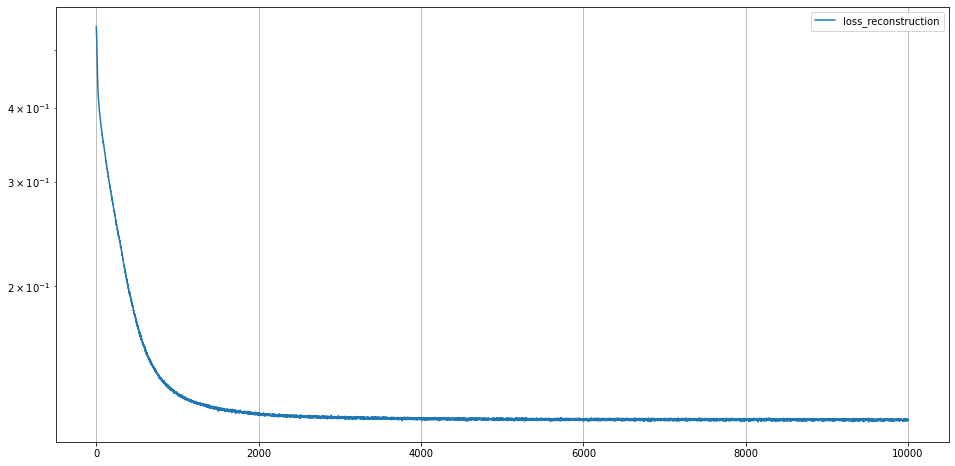

In [16]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(reconstruction)
ax.legend(['loss_reconstruction'])
ax.set_yscale('log')
ax.grid()

In [18]:
# Generation loss and discrimination loss of the last epoch
hist[-1]

[0.7060742, 1.400082]

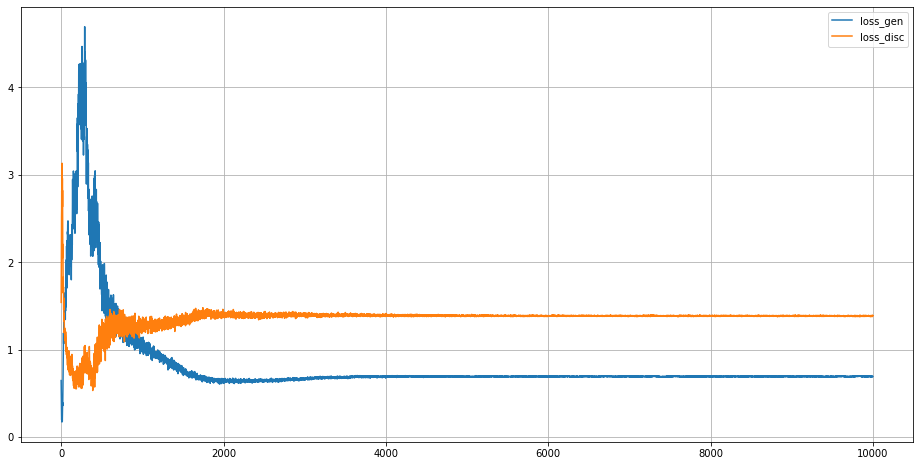

In [17]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(hist)
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

### Try improved one

In [11]:
input_timestamps = 9

def make_encoder_model():
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(128, (3, 3), input_shape = (ntimes, ncoeffs, 1), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Conv2D(32, (3, 3), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(0.2))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(latent_dim))

  return model

def make_decoder_model():
  model = keras.Sequential()
  model.add(keras.layers.Dense(ntimes*ncoeffs*32, use_bias=False, activation = 'relu', input_shape = (latent_dim,)))
  model.add(keras.layers.Reshape((input_timestamps, ncoeffs, 32)))

  model.add(keras.layers.Conv2DTranspose(64, (3, 3), padding = 'same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(128, (3, 3), padding = 'same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(1, (3, 3), padding = 'same', output_padding=[0,0], use_bias=False, activation='sigmoid'))

  return model

def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(256, activation="relu", input_shape=(latent_dim,)))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(128, activation="relu"))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(64, activation="relu"))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(1))

  return model

In [12]:
encoder = make_encoder_model()
decoder = make_decoder_model()
discriminator = make_discriminator_model()

autoencoder = keras.Sequential([encoder, decoder])
encoder_disc = keras.Sequential([encoder, discriminator])

In [13]:
r_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
@tf.function
def compute_reconstruction_loss(x, x_logit):
    """
    Calculate mean square error 
    between the input of the encoder 
    and the output of the decoder 
    
    Parameters
    ----------
    x : Tensor 
      the input of the encoder
    x_logit : Tensor
      the output of the decoder

    Returns
    -------
    Tensor
      mean squared loss between x and x_logit
    """  
    reconstruction_loss = mse(x, x_logit)
    return reconstruction_loss

@tf.function
def compute_discriminator_loss(fake_output, real_output):
    """
    Calculate cross entropy loss 
    between random noise and one, 
    the output of the encoder and zero 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
    real_output : Tensor
      the result of the discriminator 
      on the output of random noise
      
    Returns
    -------
    Tensor
      the discrimination result
      on the output of the encoder and random noise
    """  
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def compute_generator_loss(fake_output):
    """
    Calculate cross entropy loss 
    between the output of the encoder and one 
    
    Parameters
    ----------
    fake_output : Tensor 
      the result of the discriminator 
      on the output of the encoder 
      
    Returns
    -------
    Tensor
      the cross entropy loss
      between the output of the encoder and one 
    """    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

reconstruction_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [14]:
# Notice the use of `tf.function` for speeding up calculation
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    # Autoencoder update
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch, training=True)
        decoder_output = decoder(encoder_output, training=True)
        reconstruction_loss = compute_reconstruction_loss(batch, decoder_output)

    r_gradients = ae_tape.gradient(reconstruction_loss, encoder.trainable_variables + decoder.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, encoder.trainable_variables + decoder.trainable_variables))

    # Discriminator update
    with tf.GradientTape() as d_tape:
        z = encoder(batch, training=True)
        true_z = tf.random.normal(shape=(z.shape))
        fake_output = discriminator(z, training=True)
        true_output = discriminator(true_z, training=True)
        discriminator_loss = compute_discriminator_loss(fake_output, true_output)
    d_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    # Generator update
    with tf.GradientTape() as g_tape:
        z = encoder(batch, training=True)
        fake_output = discriminator(z, training=True)
        generator_loss = compute_generator_loss(fake_output)
    g_gradients = g_tape.gradient(generator_loss, encoder.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, encoder.trainable_variables))

    reconstruction_mean_loss(reconstruction_loss)
    generator_mean_loss(generator_loss)
    discriminator_mean_loss(discriminator_loss)

def train(dataset, epochs):
    hist = []
    aeloss = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1, epochs))   
        for batch in dataset:
          # print(batch.shape)
          train_step(batch)

        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])
        aeloss.append(reconstruction_mean_loss.result().numpy())

        # Resets all of the metric state variables.
        # This function is called between epochs/steps, when a metric is evaluated during training.
        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        reconstruction_mean_loss.reset_states()

        print("encoder loss: ", hist[-1][0]," - ", "discriminator loss: ", hist[-1][1])
        print("autoencoder loss: ", aeloss[-1])
        
        if epoch > 0 and (epoch+1)%1000 == 0:
            # Plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_enc', 'loss_disc'])
            #ax.set_yscale('log')
            ax.grid()
            plt.show()
         
    return hist, aeloss

Epoch 1/8000


2022-07-21 17:25:25.966153: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202


encoder loss:  0.39633593  -  discriminator loss:  2.2854495
autoencoder loss:  0.073833555
Epoch 2/8000
encoder loss:  0.040742572  -  discriminator loss:  5.5412197
autoencoder loss:  0.053380754
Epoch 3/8000
encoder loss:  0.004566291  -  discriminator loss:  8.257987
autoencoder loss:  0.044268448
Epoch 4/8000
encoder loss:  0.01423486  -  discriminator loss:  10.41635
autoencoder loss:  0.041638855
Epoch 5/8000
encoder loss:  0.0035960057  -  discriminator loss:  11.011125
autoencoder loss:  0.039557185
Epoch 6/8000
encoder loss:  0.0026651898  -  discriminator loss:  12.2646055
autoencoder loss:  0.038673252
Epoch 7/8000
encoder loss:  0.032640446  -  discriminator loss:  10.4098215
autoencoder loss:  0.038046632
Epoch 8/8000
encoder loss:  0.01312618  -  discriminator loss:  10.899039
autoencoder loss:  0.037758984
Epoch 9/8000
encoder loss:  0.007943281  -  discriminator loss:  10.541103
autoencoder loss:  0.03736048
Epoch 10/8000
encoder loss:  0.013217631  -  discriminator lo

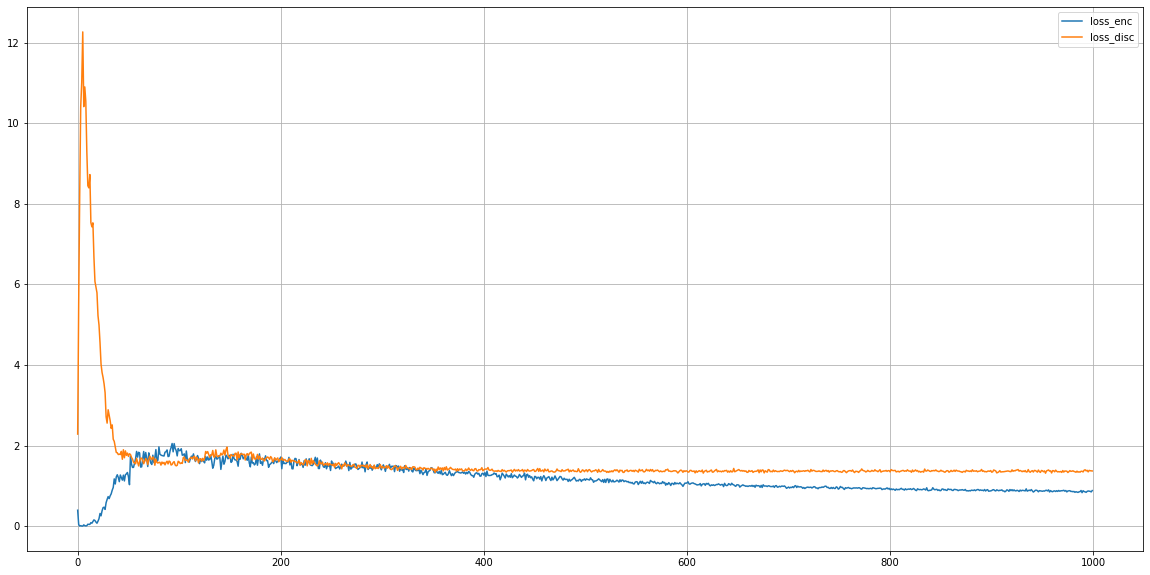

Epoch 1001/8000
encoder loss:  0.8494095  -  discriminator loss:  1.3418179
autoencoder loss:  0.00052338204
Epoch 1002/8000
encoder loss:  0.86213183  -  discriminator loss:  1.3691353
autoencoder loss:  0.0005145937
Epoch 1003/8000
encoder loss:  0.8371733  -  discriminator loss:  1.3435078
autoencoder loss:  0.00051548745
Epoch 1004/8000
encoder loss:  0.8566496  -  discriminator loss:  1.3734256
autoencoder loss:  0.00050866924
Epoch 1005/8000
encoder loss:  0.8647666  -  discriminator loss:  1.3590654
autoencoder loss:  0.000502432
Epoch 1006/8000
encoder loss:  0.8570445  -  discriminator loss:  1.3550568
autoencoder loss:  0.0005024156
Epoch 1007/8000
encoder loss:  0.88512444  -  discriminator loss:  1.3691295
autoencoder loss:  0.00051254506
Epoch 1008/8000
encoder loss:  0.8609767  -  discriminator loss:  1.3579692
autoencoder loss:  0.0005101238
Epoch 1009/8000
encoder loss:  0.853883  -  discriminator loss:  1.3451614
autoencoder loss:  0.00049027445
Epoch 1010/8000
encoder

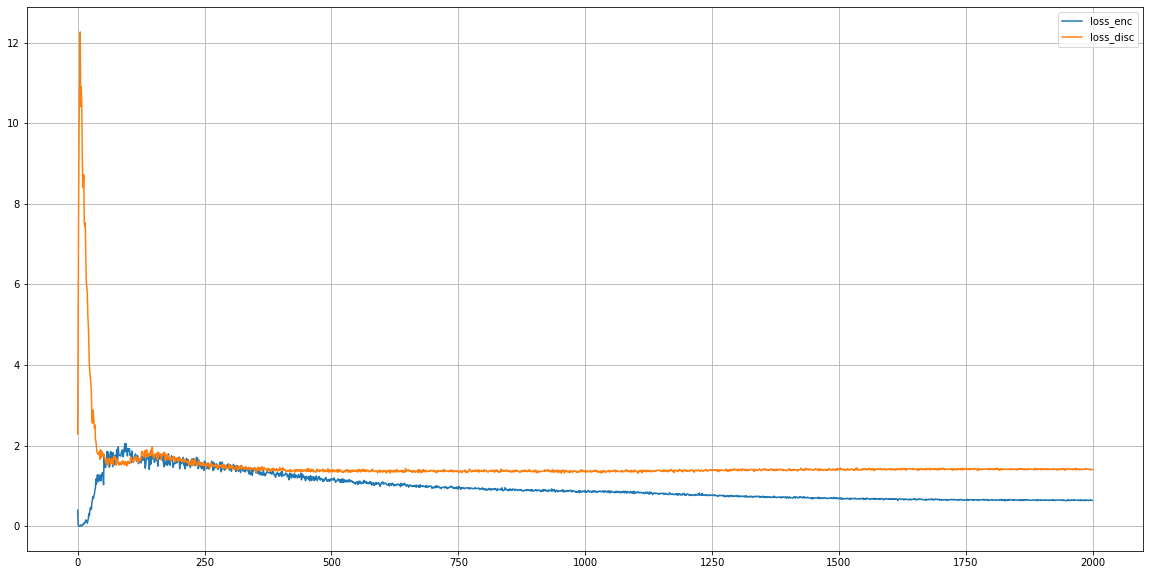

Epoch 2001/8000
encoder loss:  0.6520224  -  discriminator loss:  1.4013678
autoencoder loss:  0.00019319054
Epoch 2002/8000
encoder loss:  0.64619195  -  discriminator loss:  1.4125828
autoencoder loss:  0.00019056424
Epoch 2003/8000
encoder loss:  0.64338094  -  discriminator loss:  1.4110178
autoencoder loss:  0.00018829654
Epoch 2004/8000
encoder loss:  0.6471924  -  discriminator loss:  1.4080257
autoencoder loss:  0.00019377808
Epoch 2005/8000
encoder loss:  0.6422427  -  discriminator loss:  1.4090832
autoencoder loss:  0.00019355946
Epoch 2006/8000
encoder loss:  0.64354384  -  discriminator loss:  1.4134449
autoencoder loss:  0.00019174405
Epoch 2007/8000
encoder loss:  0.6431792  -  discriminator loss:  1.4081001
autoencoder loss:  0.00018994504
Epoch 2008/8000
encoder loss:  0.64278406  -  discriminator loss:  1.4135956
autoencoder loss:  0.00019141793
Epoch 2009/8000
encoder loss:  0.64485425  -  discriminator loss:  1.4179525
autoencoder loss:  0.00019787507
Epoch 2010/800

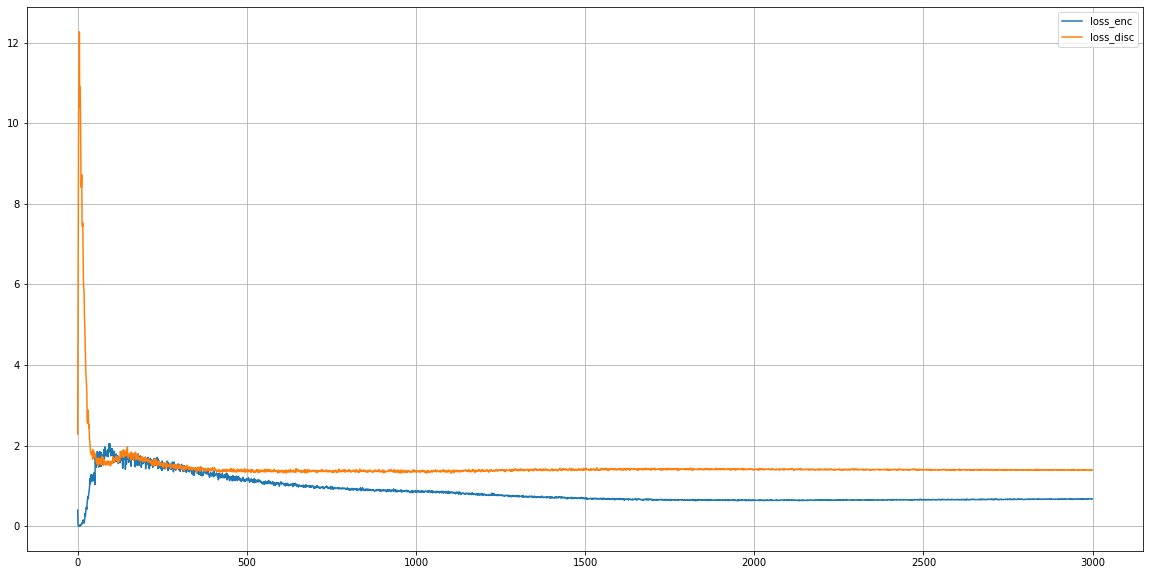

Epoch 3001/8000
encoder loss:  0.677826  -  discriminator loss:  1.3941873
autoencoder loss:  8.861616e-05
Epoch 3002/8000
encoder loss:  0.675987  -  discriminator loss:  1.4027077
autoencoder loss:  8.918769e-05
Epoch 3003/8000
encoder loss:  0.6763954  -  discriminator loss:  1.3890905
autoencoder loss:  8.724347e-05
Epoch 3004/8000
encoder loss:  0.6777885  -  discriminator loss:  1.3965844
autoencoder loss:  8.5803294e-05
Epoch 3005/8000
encoder loss:  0.67411536  -  discriminator loss:  1.3946161
autoencoder loss:  8.415554e-05
Epoch 3006/8000
encoder loss:  0.6807077  -  discriminator loss:  1.3854877
autoencoder loss:  8.4693915e-05
Epoch 3007/8000
encoder loss:  0.6822354  -  discriminator loss:  1.397007
autoencoder loss:  8.5625674e-05
Epoch 3008/8000
encoder loss:  0.67680836  -  discriminator loss:  1.3939686
autoencoder loss:  8.820416e-05
Epoch 3009/8000
encoder loss:  0.67163604  -  discriminator loss:  1.3937379
autoencoder loss:  8.447897e-05
Epoch 3010/8000
encoder l

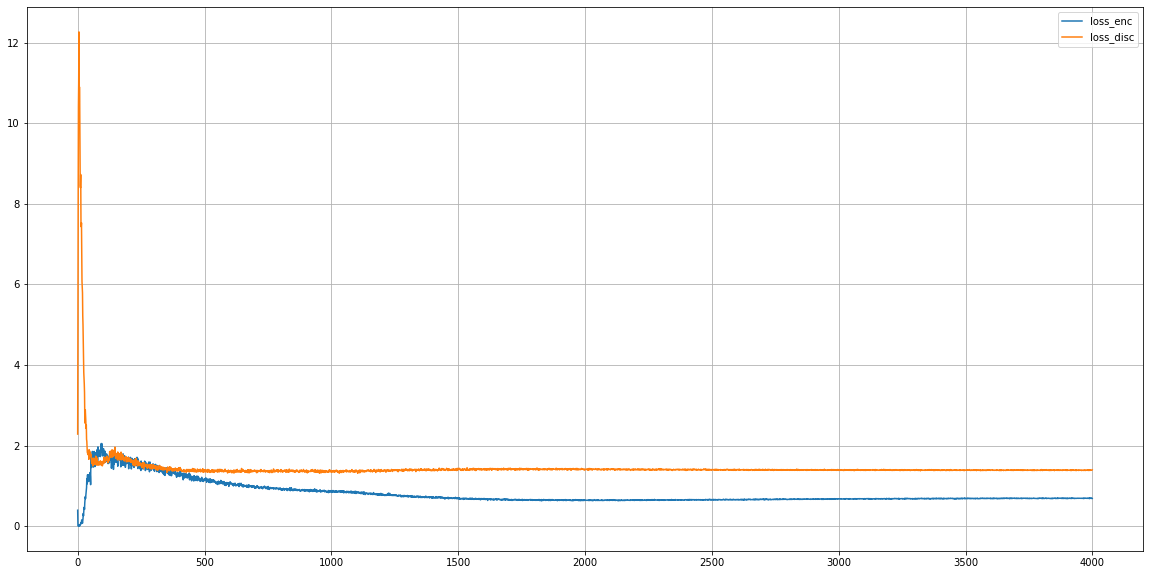

Epoch 4001/8000
encoder loss:  0.6948247  -  discriminator loss:  1.3850336
autoencoder loss:  5.6683046e-05
Epoch 4002/8000
encoder loss:  0.69364166  -  discriminator loss:  1.3907585
autoencoder loss:  5.6342982e-05
Epoch 4003/8000
encoder loss:  0.69074076  -  discriminator loss:  1.392789
autoencoder loss:  5.8399048e-05
Epoch 4004/8000
encoder loss:  0.6920617  -  discriminator loss:  1.3883013
autoencoder loss:  5.6933368e-05
Epoch 4005/8000
encoder loss:  0.69137573  -  discriminator loss:  1.3940233
autoencoder loss:  5.8675098e-05
Epoch 4006/8000
encoder loss:  0.6944426  -  discriminator loss:  1.3904928
autoencoder loss:  5.6343848e-05
Epoch 4007/8000
encoder loss:  0.69645876  -  discriminator loss:  1.3974806
autoencoder loss:  5.652952e-05
Epoch 4008/8000
encoder loss:  0.6926227  -  discriminator loss:  1.391333
autoencoder loss:  5.5732922e-05
Epoch 4009/8000
encoder loss:  0.68605024  -  discriminator loss:  1.3813611
autoencoder loss:  5.5997454e-05
Epoch 4010/8000
e

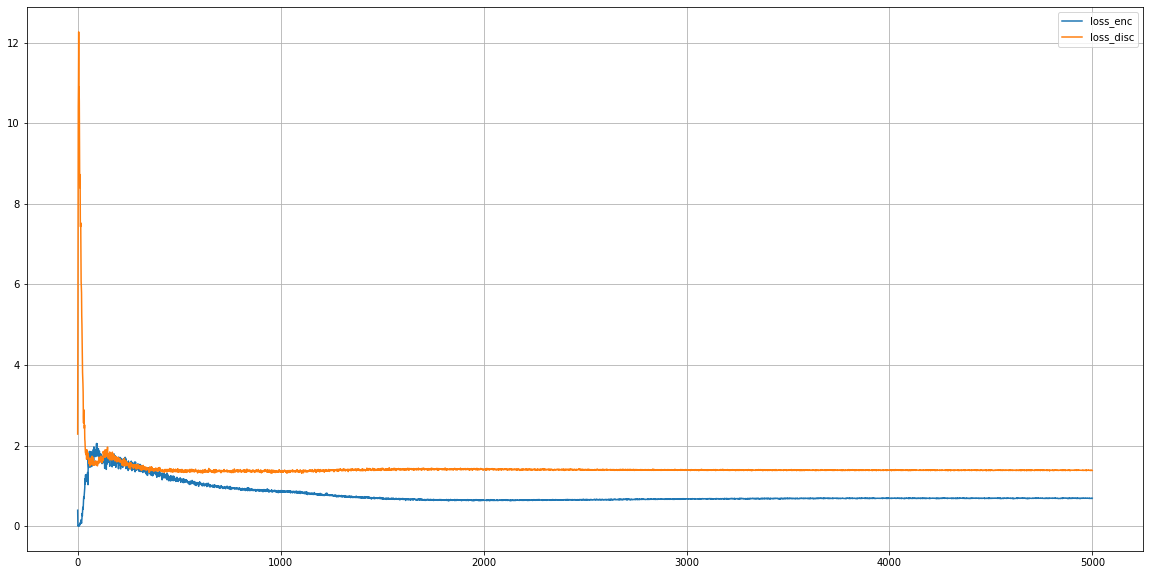

Epoch 5001/8000
encoder loss:  0.6892197  -  discriminator loss:  1.3823043
autoencoder loss:  4.139268e-05
Epoch 5002/8000
encoder loss:  0.6902025  -  discriminator loss:  1.3914709
autoencoder loss:  4.23653e-05
Epoch 5003/8000
encoder loss:  0.6903043  -  discriminator loss:  1.3879614
autoencoder loss:  4.1568546e-05
Epoch 5004/8000
encoder loss:  0.6922477  -  discriminator loss:  1.3825458
autoencoder loss:  4.0239636e-05
Epoch 5005/8000
encoder loss:  0.68844634  -  discriminator loss:  1.3873268
autoencoder loss:  4.1027964e-05
Epoch 5006/8000
encoder loss:  0.69091576  -  discriminator loss:  1.3897256
autoencoder loss:  4.0867857e-05
Epoch 5007/8000
encoder loss:  0.6932127  -  discriminator loss:  1.3912802
autoencoder loss:  4.0991417e-05
Epoch 5008/8000
encoder loss:  0.68872947  -  discriminator loss:  1.3804771
autoencoder loss:  3.8717237e-05
Epoch 5009/8000
encoder loss:  0.69193345  -  discriminator loss:  1.3852471
autoencoder loss:  3.9250586e-05
Epoch 5010/8000
en

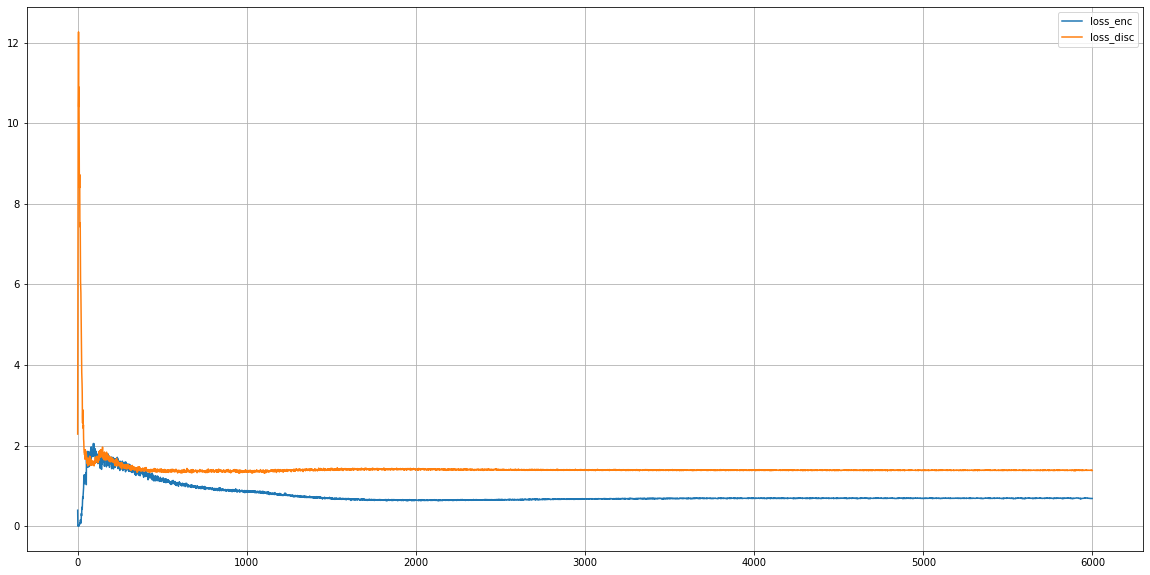

Epoch 6001/8000
encoder loss:  0.6856282  -  discriminator loss:  1.3920012
autoencoder loss:  3.170663e-05
Epoch 6002/8000
encoder loss:  0.68929225  -  discriminator loss:  1.3903366
autoencoder loss:  3.0930663e-05
Epoch 6003/8000
encoder loss:  0.68653345  -  discriminator loss:  1.3875476
autoencoder loss:  3.1957687e-05
Epoch 6004/8000
encoder loss:  0.6918731  -  discriminator loss:  1.3813089
autoencoder loss:  3.154763e-05
Epoch 6005/8000
encoder loss:  0.6908198  -  discriminator loss:  1.388421
autoencoder loss:  3.0824125e-05
Epoch 6006/8000
encoder loss:  0.6876757  -  discriminator loss:  1.3831431
autoencoder loss:  3.0739884e-05
Epoch 6007/8000
encoder loss:  0.696461  -  discriminator loss:  1.3806524
autoencoder loss:  3.068305e-05
Epoch 6008/8000
encoder loss:  0.69340974  -  discriminator loss:  1.3913761
autoencoder loss:  3.1724194e-05
Epoch 6009/8000
encoder loss:  0.69376254  -  discriminator loss:  1.3879718
autoencoder loss:  3.0631432e-05
Epoch 6010/8000
enco

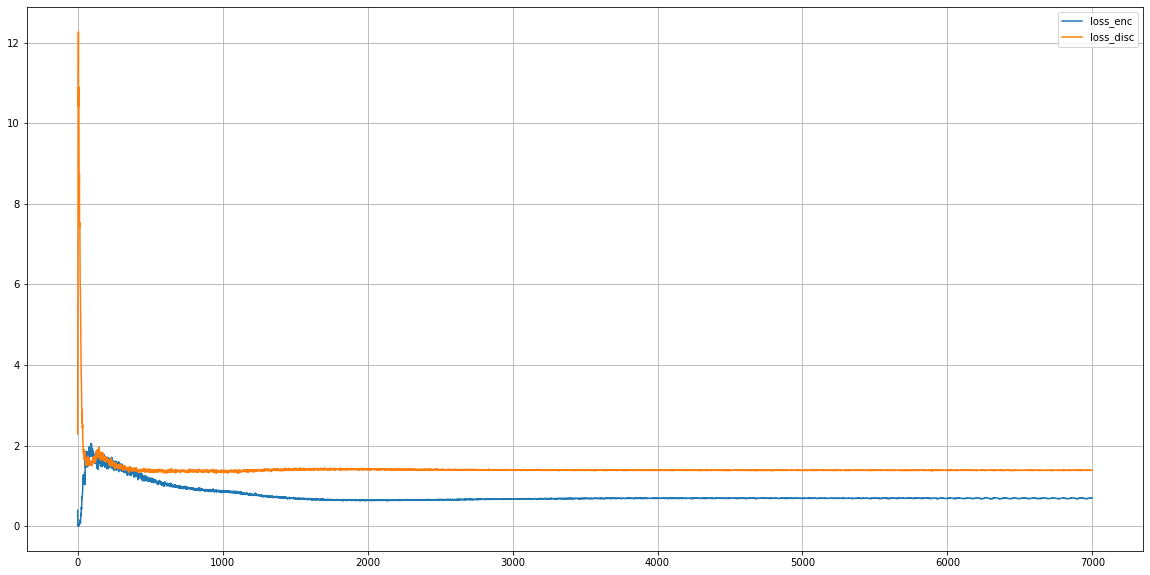

Epoch 7001/8000
encoder loss:  0.6953512  -  discriminator loss:  1.3876883
autoencoder loss:  3.33574e-05
Epoch 7002/8000
encoder loss:  0.7009418  -  discriminator loss:  1.3856262
autoencoder loss:  3.5290454e-05
Epoch 7003/8000
encoder loss:  0.69562536  -  discriminator loss:  1.3884435
autoencoder loss:  3.5539986e-05
Epoch 7004/8000
encoder loss:  0.69516116  -  discriminator loss:  1.3903509
autoencoder loss:  3.3492728e-05
Epoch 7005/8000
encoder loss:  0.6949627  -  discriminator loss:  1.3905315
autoencoder loss:  3.469794e-05
Epoch 7006/8000
encoder loss:  0.6937788  -  discriminator loss:  1.3895172
autoencoder loss:  3.5938312e-05
Epoch 7007/8000
encoder loss:  0.6933081  -  discriminator loss:  1.3861488
autoencoder loss:  3.424773e-05
Epoch 7008/8000
encoder loss:  0.6947066  -  discriminator loss:  1.384025
autoencoder loss:  3.322365e-05
Epoch 7009/8000
encoder loss:  0.69543743  -  discriminator loss:  1.3906955
autoencoder loss:  3.4217042e-05
Epoch 7010/8000
encode

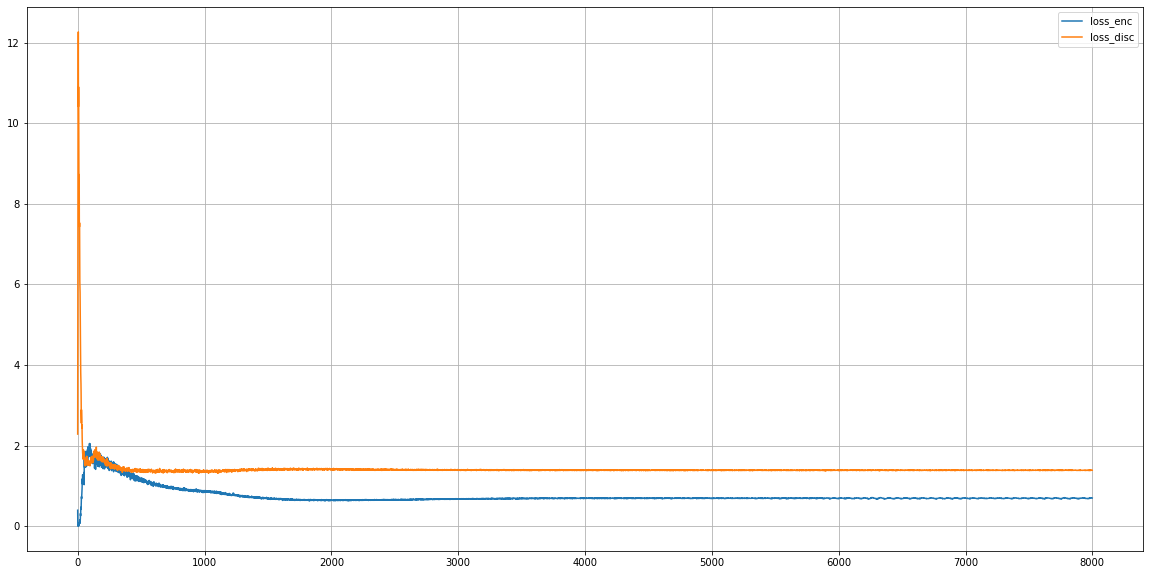

In [15]:
hist, reconstruction = train(train_dataset, epochs=8000)

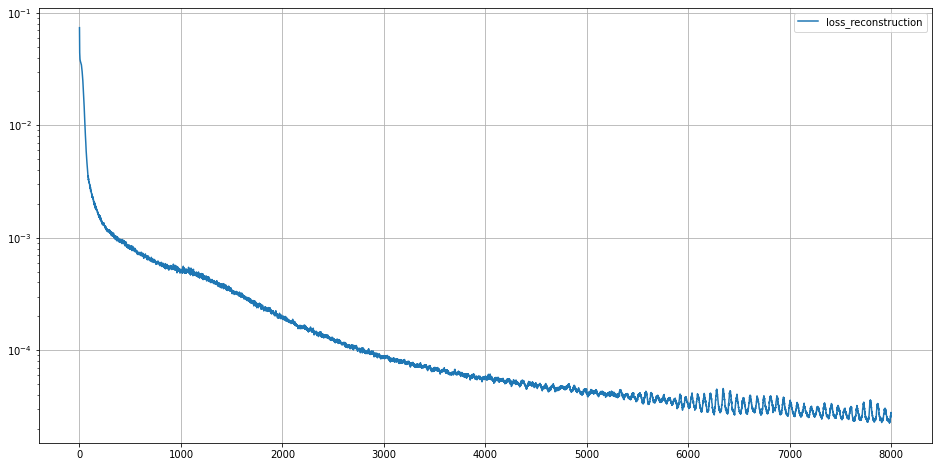

In [18]:
fig, ax = plt.subplots(1,1, figsize=[16,8])
ax.plot(reconstruction)
ax.legend(['loss_reconstruction'])
ax.set_yscale('log')
ax.grid()

In [17]:
# save trained model
autoencoder.save(root_path + 'models/ae_n{}_e{}_s{}.h5'.format(ntimes, epochs, step))
encoder_disc.save(root_path + 'models/enc_disc_n{}_e{}_s{}.h5'.format(ntimes, epochs, step))

## Test the reconstruction performance of autoencoder

### load trained model if have

In [12]:
autoencoder = load_model(root_path + 'Cotrace_fixed_720_models/aae_ae_n{}_e{}_s{}.h5'.format(ntimes, epochs, step), compile=False)

encoder, decoder = load_model(root_path + 'Cotrace_fixed_720_models/aae_ae_n{}_e{}_s{}.h5'.format(ntimes, epochs, step)).layers

<IPython.core.display.Javascript object>

### train set

2022-08-02 20:08:24.121863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202


1/1 [==============================] - 2s 2s/step


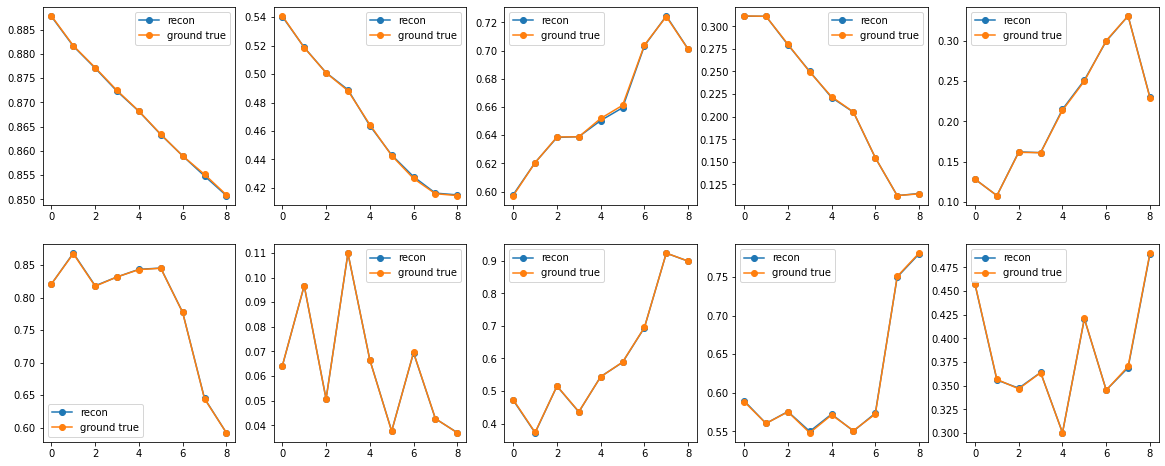

<IPython.core.display.Javascript object>

In [13]:
X_recon = autoencoder.predict(X_train_4d[26].reshape((1, ntimes, train_ct.shape[2], 1)))
X_recon = X_recon.reshape(ntimes,ncoeffs)
X_real = X_train_4d[26].reshape(ntimes,ncoeffs)

fig, ax = plt.subplots(2,5, figsize=[20,8])
for i in range(10):
    ax.flatten()[i].plot(X_recon[:,i], '-o')
    ax.flatten()[i].plot(X_real[:,i], '-o')
    ax.flatten()[i].legend(['recon', 'ground true'])

### test set

In [15]:
sample_i = 2

X_recon = autoencoder.predict(X_test_4d[sample_i].reshape((1, ntimes, test_ct.shape[2], 1)))
X_recon = X_recon.reshape(ntimes,ncoeffs)
X_real = X_test_4d[sample_i].reshape(ntimes,ncoeffs)

fig, ax = plt.subplots(3,6, figsize=[20,8])
for i in range(18):
    ax.flatten()[i].plot(X_recon[:,i], '-o')
    ax.flatten()[i].plot(X_real[:,i], '-o')
    ax.flatten()[i].legend(['recon', 'ground true'])

NameError: name 'X_test_4d' is not defined

## Prediction procedure - one point

In [ ]:
scaler = 2
num_sample = 10

nth_sensor = 5

# X_recon = model.autoencoder.predict(X_test_4d[sample_i].reshape((1, ntimes, test_ct.shape[2], 1)))
# X_recon = X_recon.reshape(ntimes,ncoeffs)
# X_real = X_test_4d[sample_i].reshape(ntimes,ncoeffs)



X_recons = []
X_initial_guesses = []
X_reals = []
fig, ax = plt.subplots(2,5, figsize=[20,8])
for i in range(10):
    
    X_recon = autoencoder.predict(X_test_4d[i*scaler].reshape((1, ntimes, test_ct.shape[2], 1)))
    X_recon = X_recon.reshape(ntimes,ncoeffs)

    X_real = X_test_4d[i*scaler].reshape(ntimes,ncoeffs)

    X_initial_guess = X_real.copy()
    X_initial_guess[-1] = X_initial_guess[-2]

    X_recons.append(X_recon)
    X_reals.append(X_real)
    X_initial_guesses.append(X_initial_guess)

    
    ax.flatten()[i].plot(X_recon[:,nth_sensor], '-o')
    ax.flatten()[i].plot(X_real[:,nth_sensor], '-o')
    ax.flatten()[i].legend(['recon', 'ground true'])

In [14]:
X_train_concat = X_train_4d
codings_size = X_compressed.shape[1]

<IPython.core.display.Javascript object>

In [18]:
mse = tf.keras.losses.MeanSquaredError()
def mse_loss(inp, outp):
    """
    Calculate mean square error 
    between real value and prediction
    
    Parameters
    ----------
    inp : numpy.ndarray 
       real POD coefficients
    ontp : numpy.ndarray
       generated values of the POD coefficients

    Returns
    -------
    float
       mean squared loss between inp and outp
    """      
    inp = tf.reshape(inp, [-1, codings_size])
    outp = tf.reshape(outp, [-1, codings_size])
    return mse(inp, outp)

<IPython.core.display.Javascript object>

In [19]:
def predict_coding(initial_pred, real_coding):
    """
    Generate predictions of m consecutive time levels
    
    Parameters
    ----------
    initial_pred : numpy.ndarray 
       initial guess of m consecutive time levels
    real_coding : numpy.ndarray
       real value of {0 - (m-2)} consecutive time levels
       
    Returns
    -------
    numpy.ndarray
       predictions for m consecutive time levels
    """  
    loss = []
    # The prediction is fed into the AAE as input, and updated through iteration
    for epoch in range(20):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:]).numpy())
        # Replace the value of the last time step of the initial input 
        # with the result of the last time step of the predicted result
        initial_pred[:,(ntimes - 1):,:,:] = decoder_output[:,(ntimes - 1):,:,:]
        
    plt.plot(loss)
    plt.grid()
    plt.show 
        
    return decoder_output,loss

<IPython.core.display.Javascript object>

In [20]:
# Choose start time level
n = 0 
real_coding = X_train_concat[n].reshape(1,-1)
# Extract the value of m-1 consecutive time levels
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = real_coding.reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
print(real_coding.shape)

# Set initial guess of m consecutive time levels:
# make the value of the last time step of the initial input 
# the same as the value of the penultimate time step
initial_pred = np.concatenate((real_coding, real_coding[:,-1:,:,:]), axis=1)
print(initial_pred.shape)

(1, 8, 550, 1)
(1, 9, 550, 1)


<IPython.core.display.Javascript object>

Loss:  9.930368e-07


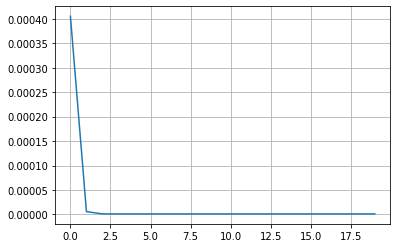

<IPython.core.display.Javascript object>

In [21]:
prediction_values,loss = predict_coding(initial_pred, real_coding)
print('Loss: ', loss[-1])

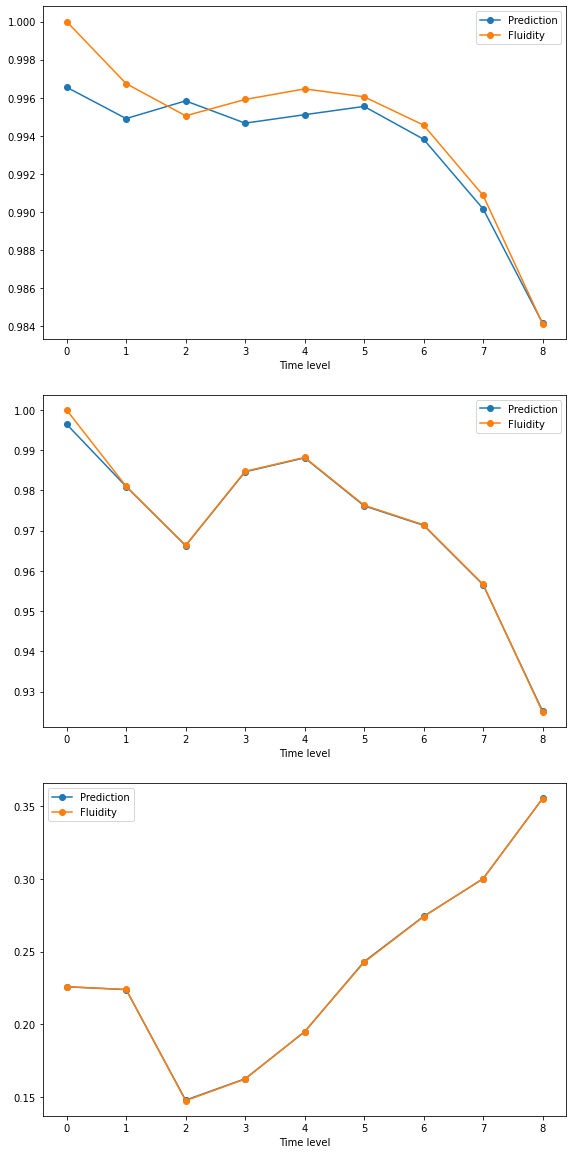

<IPython.core.display.Javascript object>

In [22]:
n_nodes = 3

fig, ax = plt.subplots(n_nodes,1, figsize=[8,16])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(n_nodes):
    ax.flatten()[i].plot((prediction_values.numpy().reshape(ntimes,codings_size))[:,i], '-o', label='Prediction')
    ax.flatten()[i].plot((X_train_4d[n].flatten().reshape(ntimes,codings_size))[:,i], '-o', label='Fluidity')
    ax.flatten()[i].legend()
    # ax.flatten()[i].set_title('Sensor '+ str(i+1))
    ax.flatten()[i].set_xlabel('Time level')
    # ax.flatten()[i].set_ylabel('CO2_ppm')

## Prediction procedure - whole prediction

### Pretict on train data

In [23]:
def predict_coding(initial_pred, real_coding):
    loss = []
    for epoch in range(20):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:]).numpy())
        initial_pred[:,(ntimes - 1):,:,:] = decoder_output[:,(ntimes - 1):,:,:]

    return decoder_output,loss

<IPython.core.display.Javascript object>

In [24]:
mse = tf.keras.losses.MeanSquaredError()
def mse_loss(inp, outp):
    """
    Calculate mean square error 
    between real value and prediction
    
    Parameters
    ----------
    inp : numpy.ndarray 
       real POD coefficients
    ontp : numpy.ndarray
       generated values of the POD coefficients

    Returns
    -------
    float
       mean squared loss between inp and outp
    """      
    inp = tf.reshape(inp, [-1, codings_size])
    outp = tf.reshape(outp, [-1, codings_size])
    return mse(inp, outp)

<IPython.core.display.Javascript object>

In [25]:
X_test_for_conv = X_train_4d
num_coeffs = 550
input_timestamps = 9
prediction_num = 100
codings_size = X_compressed.shape[1]
# tqdm
n_pred = prediction_num

<IPython.core.display.Javascript object>

### Start from time level 0

In [30]:

# Start from time level 0

n = 0
prediction_num = 720

real_value = X_test_for_conv[n].reshape(1,-1)

# Extract value of 0-(m-2) time levels as real value

real_value = real_value[:,:num_coeffs*(input_timestamps - 1)]

real_value = real_value.reshape((1, input_timestamps-1, X_test_for_conv.shape[2], 1))

# Set value of time level m-1 as same as that of time level m-2

initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)



# Predict a point forward in time (time level m-1)

prediction_values,loss = predict_coding(initial_pred, real_value)



# Update real value and initial guess

X_predict = list(prediction_values.numpy().reshape(-1,num_coeffs))

# prediction of time level m-1

gen_predict = prediction_values[:,(input_timestamps - 1):,:,:]

# Add the predicted value to the real value (time levels 1-(m-1))

real_value = np.concatenate((real_value[:,1:,:,:], gen_predict), axis=1)

# Set value of time level m as same as that of time level m-1

initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)



# Predict 10 points forward in time

for i in range(prediction_num-1):

    prediction_values,loss = predict_coding(initial_pred, real_value)

    # Update real value and initial guess

    gen_predict = prediction_values[:,(input_timestamps - 1):,:,:].numpy()

    X_predict.append(gen_predict.flatten())

    real_value = np.concatenate((real_value[:,1:,:,:], gen_predict), axis=1)

    initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)

X_predict = np.array(X_predict)

<IPython.core.display.Javascript object>

In [31]:
print(X_predict.shape)

(728, 550)


<IPython.core.display.Javascript object>

In [32]:
X_predict_scale_back = scaler_minmax_train.inverse_transform(X_predict)
X_compressed_scale_back = scaler_minmax_train.inverse_transform(X_compressed)

<IPython.core.display.Javascript object>

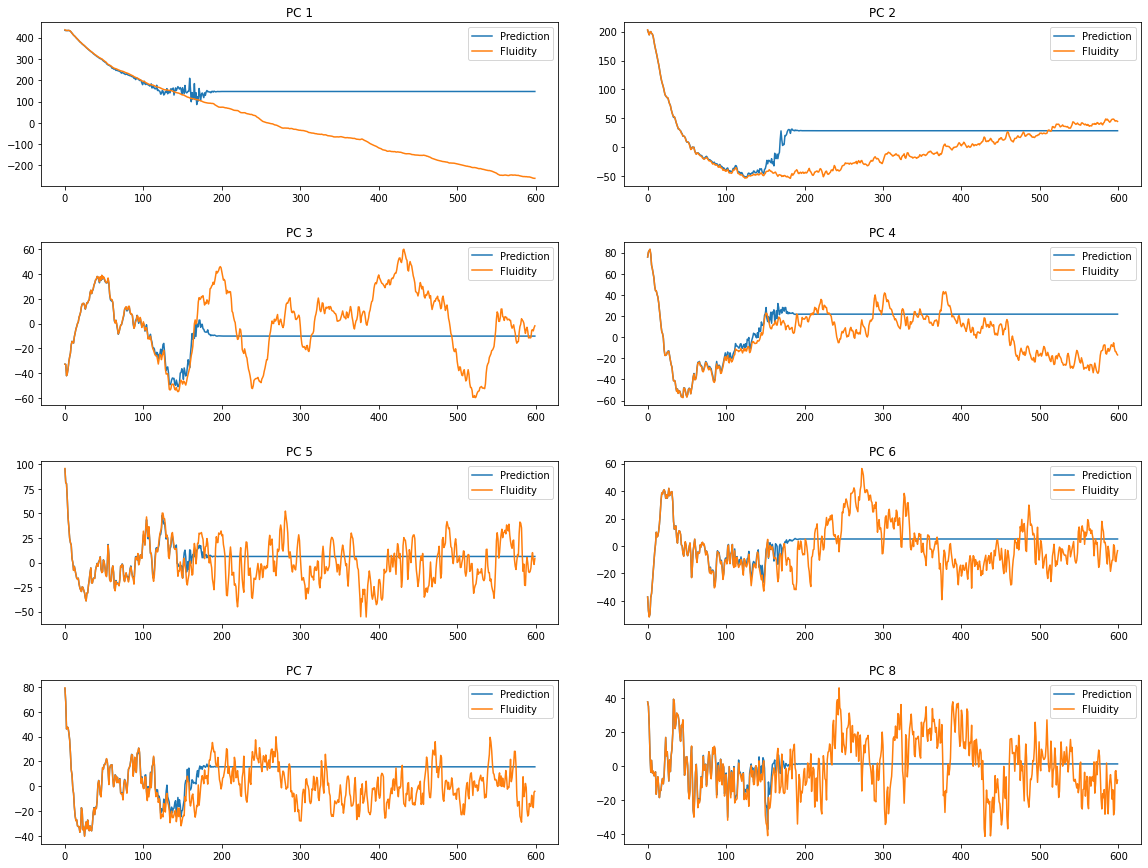

<IPython.core.display.Javascript object>

In [33]:
fig, ax = plt.subplots(4,2, figsize=[16,12])  # figsize=[16,8]
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
    ax.flatten()[i].plot(range(0, 600), X_predict_scale_back [:600,i], '-')
    ax.flatten()[i].plot(range(0,600), X_compressed_scale_back[:600,i], '-')
    ax.flatten()[i].legend(['Prediction', 'Fluidity'])
    ax.flatten()[i].set_title('PC '+ str(i+1))

### Start from time level n

In [82]:

# Start from time level n

n = 40
prediction_num = 60

real_value = X_test_for_conv[n].reshape(1,-1)

# Extract value of 0-(m-2) time levels as real value

real_value = real_value[:,:num_coeffs*(input_timestamps - 1)]

real_value = real_value.reshape((1, input_timestamps-1, X_test_for_conv.shape[2], 1))

# Set value of time level m-1 as same as that of time level m-2

initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)



# Predict a point forward in time (time level m-1)

prediction_values,loss = predict_coding(initial_pred, real_value)



# Update real value and initial guess

X_predict = list(prediction_values.numpy().reshape(-1,num_coeffs))

# prediction of time level m-1

gen_predict = prediction_values[:,(input_timestamps - 1):,:,:]

# Add the predicted value to the real value (time levels 1-(m-1))

real_value = np.concatenate((real_value[:,1:,:,:], gen_predict), axis=1)

# Set value of time level m as same as that of time level m-1

initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)



# Predict 10 points forward in time

for i in range(prediction_num-1):

    prediction_values,loss = predict_coding(initial_pred, real_value)

    # Update real value and initial guess

    gen_predict = prediction_values[:,(input_timestamps - 1):,:,:].numpy()

    X_predict.append(gen_predict.flatten())

    real_value = np.concatenate((real_value[:,1:,:,:], gen_predict), axis=1)

    initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)

X_predict = np.array(X_predict)

X_predict_scale_back = scaler_minmax.inverse_transform(X_predict)
X_compressed_scale_back = scaler_minmax.inverse_transform(X_compressed)

In [83]:
print(X_predict.shape)
print(X_compressed.shape)

(68, 90)
(100, 90)


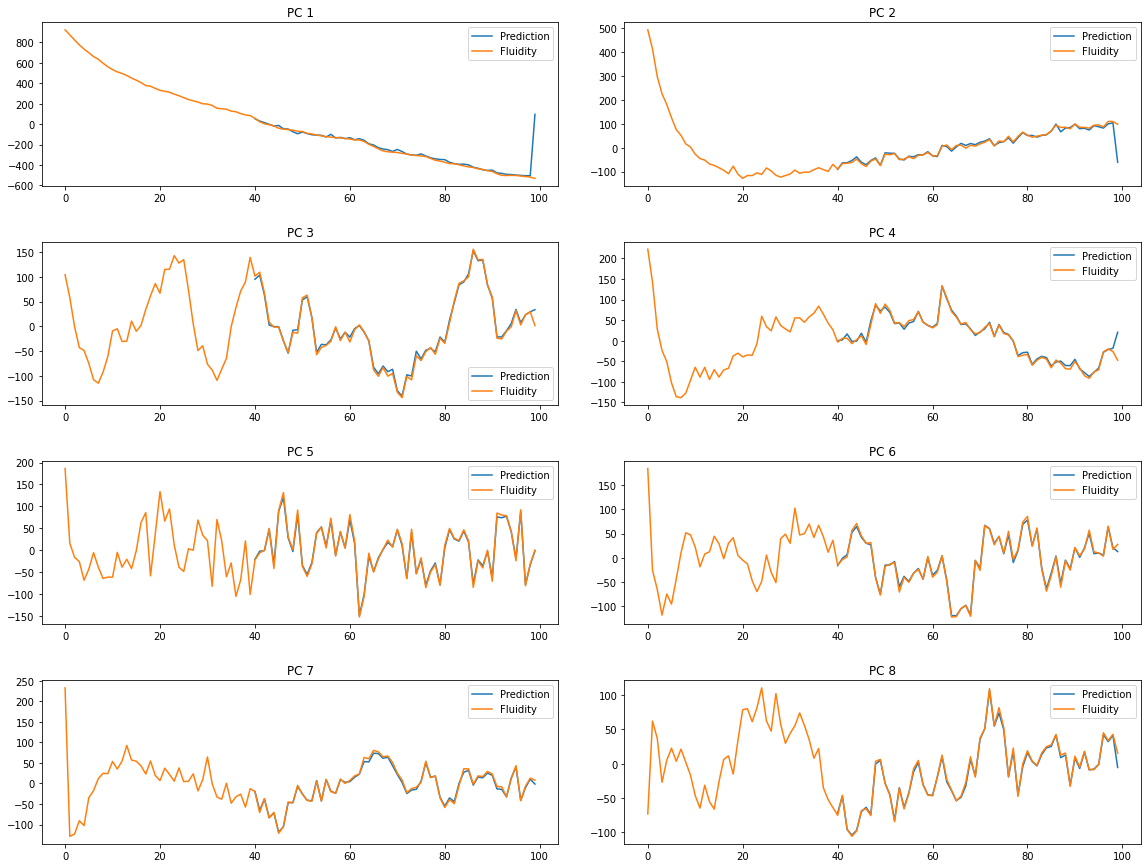

In [86]:
fig, ax = plt.subplots(4,2, figsize=[16,12])  # figsize=[16,8]
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
    ax.flatten()[i].plot(range(40, 100), X_predict_scale_back [:60,i], '-')
    ax.flatten()[i].plot(range(0,100), X_compressed_scale_back[:100,i], '-')
    ax.flatten()[i].legend(['Prediction', 'Fluidity'])
    ax.flatten()[i].set_title('PC '+ str(i+1))

### Pretict on test data

In [34]:
# test snap matrix
test_all_values = joblib.load(root_path + 'Cotrace_fixed_720_npys/test_snapshot_matrix.pkl')
print(test_all_values.shape)

(120, 1344420)


<IPython.core.display.Javascript object>

In [35]:
X_compressed_test = pca_compress.transform(test_all_values)
print(X_compressed_test.shape)

(120, 550)


<IPython.core.display.Javascript object>

In [36]:
scaler_minmax_test = MinMaxScaler((0,1))
X_compressed_test = scaler_minmax_test.fit_transform(X_compressed_test)

<IPython.core.display.Javascript object>

In [37]:
print(X_compressed_test.shape)

(120, 550)


<IPython.core.display.Javascript object>

In [38]:
Test_ct = t.concat_timesteps(X_compressed_test, ntimes, step)

# Test_ct, _ = t.train_test_split(X_compressed_test, testFrac=0.0)

# Test_dataset, X_Test_4d = t.create_dataset(Test_ct, 90, ntimes, BATCH_SIZE)

<IPython.core.display.Javascript object>

In [40]:
Test_ct_4d = Test_ct.reshape(-1,ntimes,ncoeffs,1)

<IPython.core.display.Javascript object>

In [41]:
print(Test_ct.shape)
print(Test_ct_4d.shape)

(111, 9, 550)
(111, 9, 550, 1)


<IPython.core.display.Javascript object>

In [48]:
X_test_concat = Test_ct_4d
codings_size = X_compressed_test.shape[1]

n = 0
real_coding = X_test_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = real_coding.reshape((1, ntimes-1, X_test_concat.shape[2], 1))
initial_pred = np.concatenate((real_coding, real_coding[:,-1:,:,:]), axis=1)

prediction_values,loss = predict_coding(initial_pred, real_coding)

# Update real value and initial guess
X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
gen_predict = prediction_values[:,(ntimes - 1):,:,:]
real_coding = np.concatenate((real_coding[:,1:,:,:], gen_predict), axis=1)
initial_pred = np.concatenate((real_coding, real_coding[:,-1:,:,:]), axis=1)

n_pred = 20
# Predict all points forward in time
for i in range(n_pred):
    prediction_values,loss = predict_coding(initial_pred, real_coding)
    # Update real value and initial guess    
    gen_predict = prediction_values[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding[:,1:,:,:], gen_predict), axis=1)
    initial_pred = np.concatenate((real_coding, real_coding[:,-1:,:,:]), axis=1)
X_predict = np.array(X_predict)

<IPython.core.display.Javascript object>

In [49]:
print(X_predict.shape)
print(X_compressed_test.shape)

(29, 550)
(120, 550)


<IPython.core.display.Javascript object>

In [50]:
X_predict_scale_back = scaler_minmax_test.inverse_transform(X_predict)
X_compressed__test_scale_back = scaler_minmax_test.inverse_transform(X_compressed_test)

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'PredAAE prediction results on Test set')

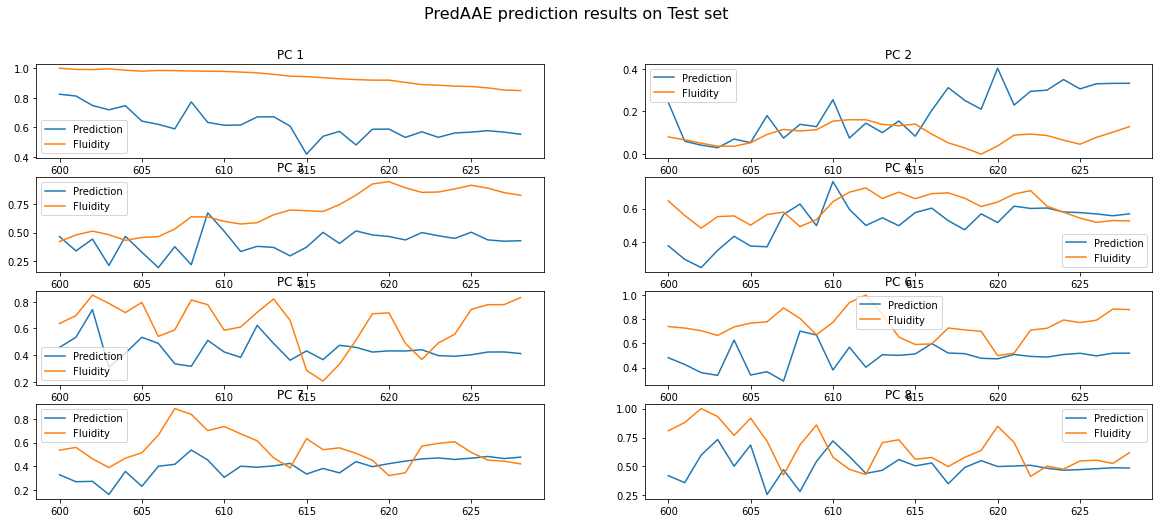

<IPython.core.display.Javascript object>

In [63]:
fig, ax = plt.subplots(4,2, figsize=[20,8])
for i in range(8):
    ax.flatten()[i].plot(range(600, 600+9+n_pred), X_predict[:X_predict.shape[0],i], '-')
    ax.flatten()[i].plot(range(600, 600+9+n_pred), X_compressed_test[n:X_predict.shape[0],i], '-')
    ax.flatten()[i].legend(['Prediction', 'Fluidity'])
    ax.flatten()[i].set_title('PC '+ str(i+1))

fig.suptitle('PredAAE prediction results on Test set', fontsize=16)

In [53]:
# save predictions
X_predict_pca_inverse = pca_compress.inverse_transform(X_predict)

In [54]:
np.save(root_path + 'aae_test_pred.npy', X_predict)
np.save(root_path + 'aae_test_pred_pac_inverse.npy', X_predict_pca_inverse)